# Creating new Product Images with Compute

The Compute module provides scalable compute capabilities to parallelize your computations. Compute enables users to package and execute your Python code within nodes hosted on Descartes Lab's cloud infrastructure. These nodes offer the ability to access imagery at extremely high rates of throughput to execute computations over nearly any spatio-temporal scale. 

In this example notebook, we will create a function to calculate and create an NDVI product from Sentinel-2 L2A imagery then test it over Yakima County in Washington. The Yakima Valley contains ~75% of the total US hop acreage. 

First, we'll start by importing the descarteslabs Python client and the compute module and point to the Enterprise Accelerator on AWS.

**Note:** The new AWS Batch Compute service is only available via `descarteslabs` version 2.0.0. Please run the following once before running the demo to install the correct `descarteslabs` client version.

In [1]:
# Install edge client of descarteslabs
!pip install -U git+https://github.com/descarteslabs/descarteslabs-python.git

  Cloning https://github.com/descarteslabs/descarteslabs-python.git to /tmp/pip-req-build-w660hdp3
  Running command git clone --filter=blob:none --quiet https://github.com/descarteslabs/descarteslabs-python.git /tmp/pip-req-build-w660hdp3
  Resolved https://github.com/descarteslabs/descarteslabs-python.git to commit 58d0681b1aa0417928ad9b4b1aaf408cf5e38822
  Preparing metadata (setup.py) ... done


In [1]:
import descarteslabs as dl
dl.select_env(dl.AWS_ENVIRONMENT)
# Check that we are working with the AWS offering and correct version
print("descarteslabs version:", dl.__version__)
print("Current Env: ", dl.get_settings().peek_settings().current_env)

descarteslabs version: 2.0.0rc4
Current Env:  aws-production


In [2]:
from descarteslabs import compute

Now that we have the compute module, let's look at the primary objects we'll be working with: Function and Jobs.
 * **Function:** dynamically created, serverless functions containing user submitted, compiled code that you can submit many jobs to.
 * **Job:** submitted request for a single invocation of a created Function. 
 
As a hands-on example, we'll create a local method to search for Sentinel-2 imagery over a given AOI, calculate NDVI from the red and near-infrared bands, and upload the NDVI image to our catalog product using our Catalog module. Then, we'll create a **Function** containing the NDVI method. 

In [11]:
# Get your org for namespace
org = dl.auth.Auth().payload['org']
# Create NDVI Catalog product
product = dl.catalog.Product.get_or_create(
    id=f"{org}:sentinel-2_ndvi",
    name="Sentinel-2 L2A NDVI",
)
product.save()

In [42]:
# Create NDVI band for product
bands = ['ndvi']

for band_index, band in enumerate(bands):
    # Check for Band first
    if dl.catalog.Band.get(f'{product.id}:{band}') == None:
        print(f"Creating band: {band}")
        dl.catalog.SpectralBand(
            product=product,
            name=band,
            band_index=band_index,
            data_type="Float64",
            nodata=0,
            data_range=(0.0, 1.0),
            display_range=(0.0,0.4),
        ).save()
    else:
        print(f"Band already exists: {band}")

Band already exists: ndvi


In [5]:
print("Product status: ", product.state)  # check that product is 'saved'
print("Product ID: ", product.id)  # Get product ID that we will pass to function later

Product status:  saved
Product ID:  descarteslabs:sentinel-2_ndvi


In [6]:
# NDVI method
def create_ndvi_image(tile_key, start_date, end_date, product_id):
    import descarteslabs as dl
    dl.select_env(dl.AWS_ENVIRONMENT)
    # Import Catalog module methods
    from descarteslabs.catalog import Product, properties as p
        
    # Get DLTile GeoContext for AOI
    dltile = dl.geo.DLTile.from_key(tile_key)
    
    # Find Sentinel-2 imagery over AOI
    images = (
        Product.get("esa:sentinel-2:l2a:v1").images()
        .intersects(dltile)
        .filter(start_date < p.acquired <= end_date)
        .filter(p.cloud_fraction < 0.1)
    ).collect()
    print("Number of images: ", len(images))
    
    # Create stack of red and nir bands for NDVI calc
    stack, raster_info = images.stack(['nir', 'red'], raster_info=True)
    nir = stack[:, 0]
    red = stack[:, 1]
    
    # Calculate NDVI
    ndvi = (nir-red)/(nir+red)
    # Get max NDVI over images
    ndvi_max = ndvi.max(axis=0)
    
    # Create image for upload
    ndvi_image = dl.catalog.Image(
        name=tile_key.replace(":", "_"),
        geometry=dltile.geometry,
        product_id=product_id,
        acquired= end_date, 
    )
    
    # Upload image to catalog product
    # TODO: improve raster_meta
    upload = ndvi_image.upload_ndarray(ndvi_max, raster_meta=raster_info[-1], overwrite=True)
    print("NDVI upload ID:", upload.id)
    
    return upload.id

### Define AOI: Yakima County, Washington state
 Now that we have our function, let's define our AOI to calculate NDVI over.
 
If you have run the `07 Blob Storage.ipynb` in our Catalog guide, then you created a storage object that we can use to get a county boundary shapefile from Storage.

If not, expand and run the cell below to pull the same file in this directory. 

In [8]:
import geopandas as gpd

# Get Storage Blob
storage_file = dl.catalog.Blob.get(f"data/{org}:compute_demo/yakima_valley")
print(storage_file)

# Download and read Yakima County Zip File
yakima_shapefile = storage_file.download("yakima_county.zip")
print(yakima_shapefile)
yak = gpd.read_file(yakima_shapefile)  # "../data/CountyZoning.zip")
minx, miny, maxx, maxy = yak.total_bounds

Blob: yakima_valley
  id: data/descarteslabs:compute_demo/yakima_valley
  created: Tue May 16 20:14:07 2023


'yakima_county.zip'

In [4]:
from shapely.geometry import box

# Create bounding box to get DLTiles over
bbox = box(minx, miny, maxx, maxy)
# Create DLTile GeoContext objects to iterate over for NDVI function
dltiles = dl.geo.DLTile.from_shape(
    bbox, 
    resolution=30,  # 30 meters
    tilesize=256,
    pad=0
)
# Get list of DLTile keys
dltile_keys = [tile.key for tile in dltiles]

print("Number of DLTiles: ", len(dltiles))
print("Single DLTile example: ")
print(dltiles[0])

Number of DLTiles:  302
Single DLTile example: 
DLTile(key='256:0:30.0:10:28:664',
       resolution=30.0,
       tilesize=256,
       pad=0,
       crs='EPSG:32610',
       bounds=(715040.0, 5099520.0, 722720.0, 5107200.0),
       bounds_crs='EPSG:32610',
       geometry=<POLYGON ((-1....219 46.08...>,
       zone=10,
       ti=28,
       tj=664,
       geotrans=(715040.0, 30.0, 0.0, 5107200.0, 0.0, -30.0),
       proj4='+proj=utm +z...s=m +no_defs ',
       wkt='PROJCS["WGS ...SG","32610"]]',
       all_touched=False)


### Testing function
Let's test the NDVI method locally and see the images uploaded to the Catalog product we created.

In [ ]:
# Test start and end dates
start_date = "2021-06-01"
end_date = "2021-06-15"
# Submit request for NDVI image upload
ndvi_test = create_ndvi_image(dltile_keys[0], 
                              product_id=product.id,
                              start_date=start_date, end_date=end_date)

In [19]:
# Compare upload ID
product.image_uploads().collect()
# Check if new images are in Catalog product
img = product.images().filter(start_date < dl.catalog.properties.acquired <= end_date).collect()
img

ImageCollection of 1 image
  * Dates: Jun 05, 2021 to Jun 05, 2021
  * Products: descarteslabs:sentinel-2_ndvi: 1

In [48]:
test_arr = img[0].ndarray("ndvi")
test_arr.shape

AOI(geometry=<POLYGON ((-1....219 46.08...>,
    resolution=30.0,
    crs='EPSG:32610',
    align_pixels=False,
    bounds=(715040.0, 5099520.0, 722720.0, 5107200.0),
    bounds_crs='EPSG:32610',
    shape=None,
    all_touched=False)


(1, 256, 256)

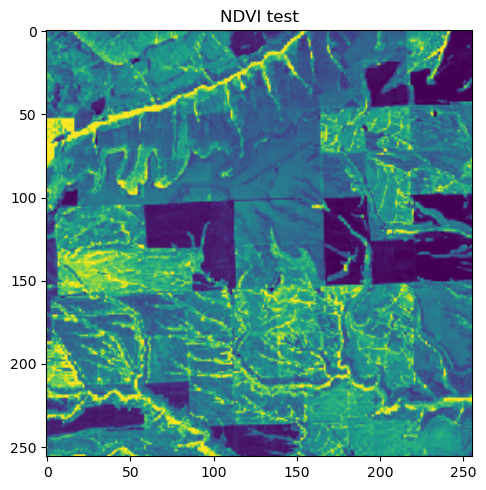

In [53]:
# Plot example of image
dl.utils.display(test_arr, title="NDVI test", size=5, colormap='viridis')

### Create Compute function


In [7]:
async_func = compute.Function(
    create_ndvi_image,
    name="NDVI-from-sentinel-2",
    image= "python3.8:master_ec20a887a6a964cf",
    cpus=1,
    memory=2,
    timeout=60*10,  # in seconds ~ currently 10 min # Must be less than 900
    maximum_concurrency=2,
    retry_count=2,
    #requirements=[
    #    "geopandas==0.13.0"
    #]
)
async_func.save()

### Submit jobs to Compute function

Now that we have a function built, we can test submitting Jobs. First, we'll submit a single job by creating a `compute.Job` object and wait for it to complete.

In [8]:
async_func = compute.Function.get(id='ae01ee96-bcc5-4c57-89e0-a5b18c75dce4')
async_func

<Function
    id='ae01ee96-bcc5-4c57-89e0-a5b18c75dce4'
    creation_date=datetime.datetime(2023, 5, 22, 18, 9, 56, 723130, tzinfo=datetime.timezone(datetime.timedelta(0), 'UTC'))
    name='NDVI-from-sentinel-2'
    image='python3.8:compute_base_images_d57ca8e49b95161a'
    cpus=2.0
    memory=4096
    maximum_concurrency=2
    status=<FunctionStatus.RUNNING: 'running'>
    timeout=600
    retry_count=2>

In [9]:
# Get the DLTile key for the first tile
key = dltiles[0].key
# Set a start_date and end_date
start_date = "2021-06-01"
end_date = "2021-06-15"

In [12]:
# Create the job function
job = compute.Job(async_func.id, args=[key, start_date, end_date, product.id])
job.save()

In [ ]:
%timeit job.wait_for_completion()

In [14]:
# Look at the results of this product
job.log()

#### Plot example image

AOI(geometry=<POLYGON ((-1....219 46.08...>,
    resolution=30.0,
    crs='EPSG:32610',
    align_pixels=False,
    bounds=(715040.0, 5099520.0, 722720.0, 5107200.0),
    bounds_crs='EPSG:32610',
    shape=None,
    all_touched=False)


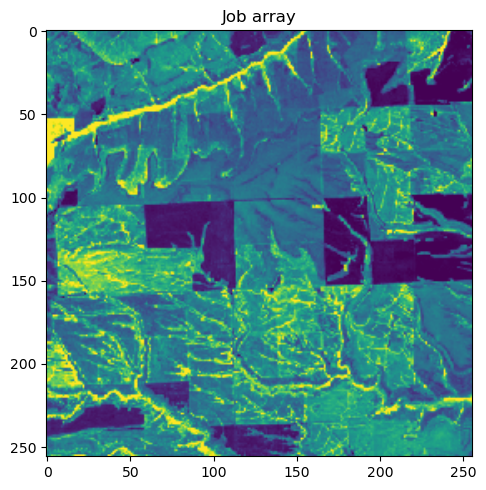

In [72]:
# Check if new images are in Catalog product
job_image = product.images().filter(start_date < dl.catalog.properties.acquired <= end_date).collect()
job_image

job_arr = job_image[0].ndarray("ndvi")
job_arr.shape

# Plot example of image
dl.utils.display(job_arr, title="Job array", size=5, colormap='viridis')

### Submit multiple jobs
We can also submit multiple jobs to the same function.

### Submit many jobs using `Function.map()`

In [27]:
func = compute.Function.get(id='ae01ee96-bcc5-4c57-89e0-a5b18c75dce4')
func

<Function
    id='ae01ee96-bcc5-4c57-89e0-a5b18c75dce4'
    creation_date=datetime.datetime(2023, 5, 22, 18, 9, 56, 723130, tzinfo=datetime.timezone(datetime.timedelta(0), 'UTC'))
    name='NDVI-from-sentinel-2'
    image='python3.8:compute_base_images_d57ca8e49b95161a'
    cpus=2.0
    memory=4096
    maximum_concurrency=2
    status=<FunctionStatus.RUNNING: 'running'>
    timeout=600
    retry_count=2>

##### Create dictionary of arguments to pass as Jobs


In [15]:
# Convenience function for building kwarg dict
def get_bulk_kwargs(jobs, **kwargs):
    bulk_kwargs = []
    for _ in range(jobs):
        bulk_kwargs.append(dict(kwargs))
        
    return bulk_kwargs

In [18]:
## Collect args to submit to Function
# Get a list of the DLTile keys
dltile_keys = [[tile.key] for tile in dltiles]  # First iterable argument needs to be list of lists - List[List]
# Test start and end dates 
start_date = "2021-06-01"
end_date = "2021-06-15"

# Build kwarg dict
kwargs = get_bulk_kwargs(len(dltiles), start_date=start_date, end_date=end_date, product_id=product.id)
print("Example of Key word args")
kwargs[0:5]

Example of Key word args


[{'start_date': '2021-06-01',
  'end_date': '2021-06-15',
  'product_id': 'descarteslabs:sentinel-2_ndvi'},
 {'start_date': '2021-06-01',
  'end_date': '2021-06-15',
  'product_id': 'descarteslabs:sentinel-2_ndvi'},
 {'start_date': '2021-06-01',
  'end_date': '2021-06-15',
  'product_id': 'descarteslabs:sentinel-2_ndvi'},
 {'start_date': '2021-06-01',
  'end_date': '2021-06-15',
  'product_id': 'descarteslabs:sentinel-2_ndvi'},
 {'start_date': '2021-06-01',
  'end_date': '2021-06-15',
  'product_id': 'descarteslabs:sentinel-2_ndvi'}]

In [28]:
# Submit multiple Jobs using map
jobs = func.map(dltile_keys, kwargs)

In [ ]:
jobs[0].wait_for_completion()

Job ca8ce733-c0e4-4d9c-af15-0143667fb5ad starting status pending


Once these jobs have completed, results can be received by iterating through the jobs associated with our Function object. 

In [ ]:
# Get results
statuses = {}

for j in async_func.jobs:
    stat = j.status
    if stat in statuses:
        statuses[stat].append(j.id)
    else:
        statuses[stat] = [j.id]

### Submit Multiple jobs

In [47]:
jobs=[]
for key in dltile_keys:
    j = compute.Job(async_func.id, args=[key, "2022-06-01", "2022-06-30", product.id])
    j.save()
    
    jobs.append(j)

In [ ]:
async_func.wait_for_completion()

Function NDVI-from-sentinel-2-ow starting status success
Function NDVI-from-sentinel-2-ow updated from success to running


## Finding previous `Functions`

Until the Compute Monitor is finalized, we will need to search for previous functions programmatically.

In [26]:
# Get active functions by specifying the "running" status
active_funcs = [{"name": f.name, "id": f.id} for f in compute.Function.list(status='running')]
active_funcs

[{'name': 'hello_gpd', 'id': 'bde698ff-66cb-4c73-9115-2c4d08fbe57e'},
 {'name': 'NDVI-from-sentinel-2',
  'id': 'ae01ee96-bcc5-4c57-89e0-a5b18c75dce4'}]

In [32]:
# Filter Functions by name prefixes
funcs = compute.Function.list()
ndvi_funcs = [f.name for f in funcs if f.name.startswith("NDVI")]
ndvi_funcs

['NDVI-from-sentinel-2', 'NDVI-from-sentinel-2-ow', 'NDVI-from-sentinel-2']